<h1> Stool microbiome and obesity </h1>

The microbiome refers to all the microorganisms that live on or within the human body. Microorganisms can be found thriving in many sites of the body, including the skin, uterus, mouth and gastrointestinal tract. In fact it is estimated that there are more bacteria than cells in the human body, thus it is not surprising that studies have shown the microbiome has a significant impact on physical and even mental health. We have so much interdependence with the bacteria living on or in us, some studies have shown that the species composition of the gut microbiome is associated with many diseases, from cancer to metabolic syndrome. There is crosstalk between our body and the microbiome, our lifestyles and habits can alter the communities of our microbiome; their diversity and composition in turn affect our health.

Although I'm currently working as a forensic scientist, my graduate research was on microbiology so I am quite interested in the correlation between the  composition of an individual's stool microbiome and their physical status, especially any genus/species of bacteria that are important for the prediction of obesity. This would be a good opportunity to practice my analytics skills too, since I don't get to use them much in my day to day work too.

The dataset I'm using is a human metagenomics dataset from Kaggle which can be found [here](https://www.kaggle.com/antaresnyc/human-metagenomics?select=abundance_stoolsubset.csv). Credits for the data go to the original authors of the study and Kaggle user Alexey Kotlik who uploaded it.

<sub> All code cells are hidden by default, click on the button to display them </sub>

### Data cleaning and explorations ###

In [1]:
### import packages ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

### import raw data

data = pd.read_csv('metagenomics/abundance_stoolsubset.csv', dtype='str')
cols = data.columns

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# Let's take a look at the raw data

print('sample dimensions are {} rows by {} columns'.format(data.shape[0], data.shape[1]))
print()
data.head(2)

sample dimensions are 1989 rows by 2339 columns



,dataset_name,sampleID,subjectID,bodysite,disease,age,gender,country,sequencing_technology,pubmedid,...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gilvus|t__Enterococcus_gilvus_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis|t__GCF_000415925,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis|t__GCF_000215085,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|t__GCF_000209855,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1|t__GCF_000478965
0,Candela_Africa,H10,h10,stool,n,40,female,tanzania,Illumina,25981789,...,0,0,0,0,0,0,0,0,0,0
1,Candela_Africa,H11,h11,stool,n,29,female,tanzania,Illumina,25981789,...,0,0,0,0,0,0,0,0,0,0


This dataset is pretty high dimensional with 2339 columns, but most of the columns are not really relevant to what I'm doing. Gender, age and country is available too, which gives me an idea to try something similar to this but see if I can differentiate gender or location based on microbiome. But that'll be something for the future.

Since I'm interested in obesity, I'll filter for that data with indicators of obesity and normal weight individuals. I got my BMI categories here from [NIH](https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmicalc.htm), which is:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-c3ow">Underweight</th>
    <th class="tg-c3ow">&lt;18.5</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-c3ow">Normal weight</td>
    <td class="tg-c3ow">18.5-24.9</td>
  </tr>
  <tr>
    <td class="tg-c3ow">Overweight</td>
    <td class="tg-c3ow">25-29.9</td>
  </tr>
  <tr>
    <td class="tg-c3ow">Obesity</td>
    <td class="tg-c3ow">&gt;=30</td>
  </tr>
</tbody>
</table>

In the cell below, I drop the columns which I won't be using, except for some that identifies where the sample is from. I won't be using data from individuals with other diseases, only those who are healthy or obese, so as to not add any confounding variables or other complications in the modeling.

In [2]:
### preprocess data ###

# filter for categories of interest

processed = data[data['disease'].isin(['obesity', 'obese', 'overweight','leaness', 'n'])].copy()

# drop columns that are not needed
to_drop = list(cols[2:4]) + list(cols[8:20]) + list(cols[21:211])
processed.drop(columns = to_drop, inplace = True)

# remove samples without bmi, convert bmi and abundance to float and filter for regular weight and obese
processed = processed[~processed['bmi'].isin(['na', 'nd'])]

processed['bmi'] = pd.to_numeric(processed['bmi'], downcast ='float')

# processed.iloc[:, 7:] = processed.iloc[:, 7:].apply(pd.to_numeric)

processed.iloc[:, 7:] = processed.iloc[:, 7:].astype(np.float32)
# create labels for classification

bmi = [(processed['bmi'] >= 18.5) & (processed['bmi'] < 25), (processed['bmi'] >= 25) & (processed['bmi'] < 30), processed['bmi'] >= 30 ]

categories = ['1','2','3']

classes = np.select(bmi, categories, default = '0')

np.unique(classes, return_counts=True)

(array(['0', '1', '2', '3'], dtype='<U1'),
 array([ 35, 444, 177, 309], dtype=int64))

There are too little observations for underweight data, which will affect the modeling accuracy. Since I'm curious about the microbiome composition of regular and obese individuals (classes 1 and 3), I'll just drop the classes I'm not interested in rather than getting bogged down in dealing with the data imbalance.

In [3]:
bmi = [(processed['bmi'] >= 18.5) & (processed['bmi'] < 25), processed['bmi'] >= 30 ]

categories = ['0','1']

processed['bmi_category'] = np.select(bmi, categories, default = '2')

I also noticed some "redundancy" in the relative abdundance data which should be removed after the initial data cleaning:

The relative abundance for every species is recorded multiple times in the data, as an example, let's look at the data for Archaea bacteria for the $6^{th}$ observation

In [ ]:
processed.iloc[5, 7:16]

k__Archaea                                                                                                                                                                                     0.4308
k__Archaea|p__Euryarchaeota                                                                                                                                                                    0.4308
k__Archaea|p__Euryarchaeota|c__Methanobacteria                                                                                                                                                 0.4308
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales                                                                                                                           0.4308
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae                                                                                                    0.4308
k__Archaea

The first letter of the name of columns stands for taxonomic rank. For example, in the output above, the first row (col 7), "k\_Archaea", is for the kingdom of [Archaea](https://en.wikipedia.org/wiki/Archaea) and sum abundance of all bacteria from this kingdom is 0.4308. Row 2, "k_Archaea|p_Euryarchaeota" is referring to the phylum of Euryarchaeota within the Archaea kingdom. (See [Bacteria Taxonomy](https://en.wikipedia.org/wiki/Bacterial_taxonomy)). Since I'm interested at the species, I'll be removing columns of other taxonomic ranks. Notice that for Methanobrevibacter smithii, there is an even lower rank which starts with "t" which refers to type, however not every species in the dataset has a type, I'll stop at the species level.

We can see that for this data point, only 2 species were detected, *M.smithii* and a unclassified methanobrevibacter, at 0.3816 and 0.04919 abundance respectively. And both values add up to 0.4308, which confirms that I'm not reading the data wrong.

I'll use regex to find column names that contain species level abundance and filter the other columns. And since I'm already filtering at the species level anyways, I'm quite curious to study genus level data as well, so I'll filter for those too. But different species of bacteria within the same genus can have different biochemistry and life cycles, so it is likely that genus will not be as good a predictor.

In [4]:
# get names of all columns that contain abundance data
bacteria = list(processed.columns)[7:-1]

# use regex to select exclusively for columns that contain species level abundance

# filters for species level
s = re.compile(r'(\|s__\w+$)')

# filter for genus level
g = re.compile(r'\|g__\w+$')


not_species = [i for i in bacteria if not s.search(i)]
not_genus = [j for j in bacteria if not g.search(j)]

# drop columns that are not needed
species_data = processed[processed['bmi_category'] != '2'].drop(columns = not_species)

genus_data = processed[processed['bmi_category'] != '2'].drop(columns = not_genus)

print('New dimensions of the dataset:')
print()
print('Species level dataset: {} rows by {} cols'.format(species_data.shape[0], species_data.shape[1]))
print()
print('Genus level dataset: {} rows by {} cols'.format(genus_data.shape[0], genus_data.shape[1]))


New dimensions of the dataset:

Species level dataset: 753 rows by 834 cols

Genus level dataset: 753 rows by 300 cols


Next is to shorten the feature names into something more readable:

In [5]:
# rename feature names to shorter ones for species

s = re.compile(r's__(\w+)')

short = []

for i in list(species_data)[7:-1]:
    short.append(s.search(i).group(1).replace("_", " "))
    
new = dict(zip(species_data, list(species_data)[:7] + short))

species_data.rename(columns = new, inplace=True)

# same thing for genus

g = re.compile(r'g__(\w+)')

short = []

for i in list(genus_data)[7:-1]:
    short.append(g.search(i).group(1).replace("_", " "))
    
new = dict(zip(genus_data, list(genus_data)[:7] + short))

genus_data.rename(columns = new, inplace=True)

Now to do a check on the data, first for missing values. Also, since this is a relative abundance dataset, the total values in each observation should add up to 100:

In [ ]:
# quick and dirty missing value check

print('there are {} missing values in species and {} in genus.'.format(species_data.isna().sum().sum(), genus_data.isna().sum().sum()))

there are 0 missing values in species and 0 in genus.


In [ ]:
# a list to collect index of observations that add up to 0 or more than 100
gt = []
lt = []
for i in range(len(species_data)):
    if (species_data.iloc[i, 7:-1].sum() > 100):
        gt.append(i)
    elif species_data.iloc[i, 7:-1].sum() < 100:
        lt.append(i)

print('{} observations >100% and {} observations <100% to check'.format(len(gt), len(lt)))


105 observations >100% and 627 observations <100% to check


That's a lot of observations with issues, let's take a look at those that add up to less than 100 first.

In [ ]:
for i in np.random.randint(0, len(lt), size=10):
    print('row {}, total abundance {}'.format(lt[i], species_data.iloc[lt[i], 7:-1].sum()))


row 474, total abundance 99.9999771118164
row 588, total abundance 99.95809936523438
row 122, total abundance 99.80704498291016
row 298, total abundance 99.97821807861328
row 178, total abundance 99.99571228027344
row 41, total abundance 99.79571533203125
row 493, total abundance 99.6502685546875
row 241, total abundance 99.9721450805664
row 658, total abundance 99.96732330322266
row 544, total abundance 99.9976806640625


And those that add up to more than 100

In [ ]:
for i in np.random.randint(0, len(gt), size=10):
    print('row {}, total abundance {}'.format(gt[i], species_data.iloc[gt[i], 7:-1].sum()))

row 65, total abundance 100.00003051757812
row 572, total abundance 100.00003051757812
row 735, total abundance 100.0000228881836
row 326, total abundance 100.00001525878906
row 88, total abundance 100.00000762939453
row 590, total abundance 100.00004577636719
row 334, total abundance 100.00003051757812
row 413, total abundance 100.00007629394531
row 666, total abundance 100.00003814697266
row 375, total abundance 100.00003814697266


It seems like the issue is due to floating point imprecision or rounding errors, it shouldn't affect the modeling then.

Now that I'm happy with the state of the data, let's take a deeper look into the data.

First let's look at the correlation between the variables and the classes. In this case, I'm looking for correlation between dichotomous categorical variables, the 2 classes and continuous variables which are not normally distributed. (In case you were wondering, my earlier explorations into the data showed me the data is mostly sparse and not normally distributed.) So in this case, I use the Mann-Whitney U test and calculate [rank-biserial correlation](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test#Rank-biserial_correlation) for class and each species of bacteria.

The logic that I'm working on here, is that species with high correlation to the dependent variable should have a significant difference in their distribution between the classes, which I can hopefully visualise in a histograms. Since there are so many species, I'll put the correlation on a scatterplot and then the distributions of the 10 species with the highest correlation to obesity and normal weight.

The dataset is quite sparse and widely spread, so I'll have to plot on a $log_{10}$ scale for visualisation. Since the sparsity will then give me problems, what I'll do is add 0.00001 to the data before plotting them, so note that $10^{-5}$ on the x-axis simply means the abundance is 0%.


In [6]:
def calculate_mann_whitney(df, column_name):
    '''Calculates mann_whitney U rank test rank-biserial correlation
    Assumes the data has only 2 classes, 1 and 0
    and the last column contains the classes'''

    from scipy.stats import mannwhitneyu
    
    # dictionary to collect data
    variables = {}

    for i in range(len(df.columns)-1):
        class0 = df[df.columns[i]][df[column_name] == '0']
        class1 = df[df.columns[i]][df[column_name] == '1']

        u = mannwhitneyu(class0, class1)[0]

        # the calculation of rank-biserial correlation changes depending on whether the test statistic, U, is the smaller one
        # since scipy always returns the test statistic of the first argument, rather than do 2 Mann-Whitney tests to get
        # both U1 and U2 to compare. I'll just stick to one calculation and absolute it to get the correlation regardless
        # of whether U is larger or smaller 
        variables[df.columns[i]]= np.absolute((2 * u)/(len(class0)*len(class1)) - 1)

    return pd.DataFrame.from_dict(variables, orient='index', columns = ['rank_biserial'])

([], [])

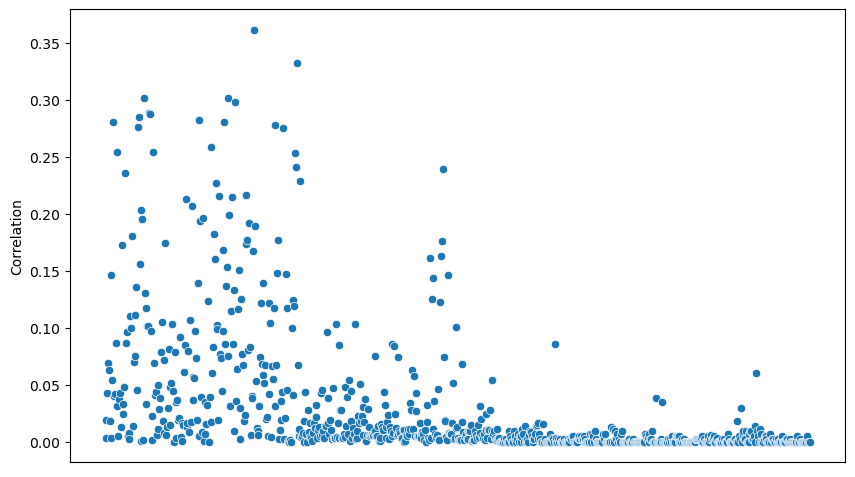

In [7]:
species_mann = calculate_mann_whitney(species_data.iloc[:, 7:], 'bmi_category')

plt.figure(figsize=(10,6), dpi=100)
sns.scatterplot(data=species_mann, y = 'rank_biserial', x = species_mann.index.values)
plt.ylabel('Correlation')
plt.xticks(ticks = [])

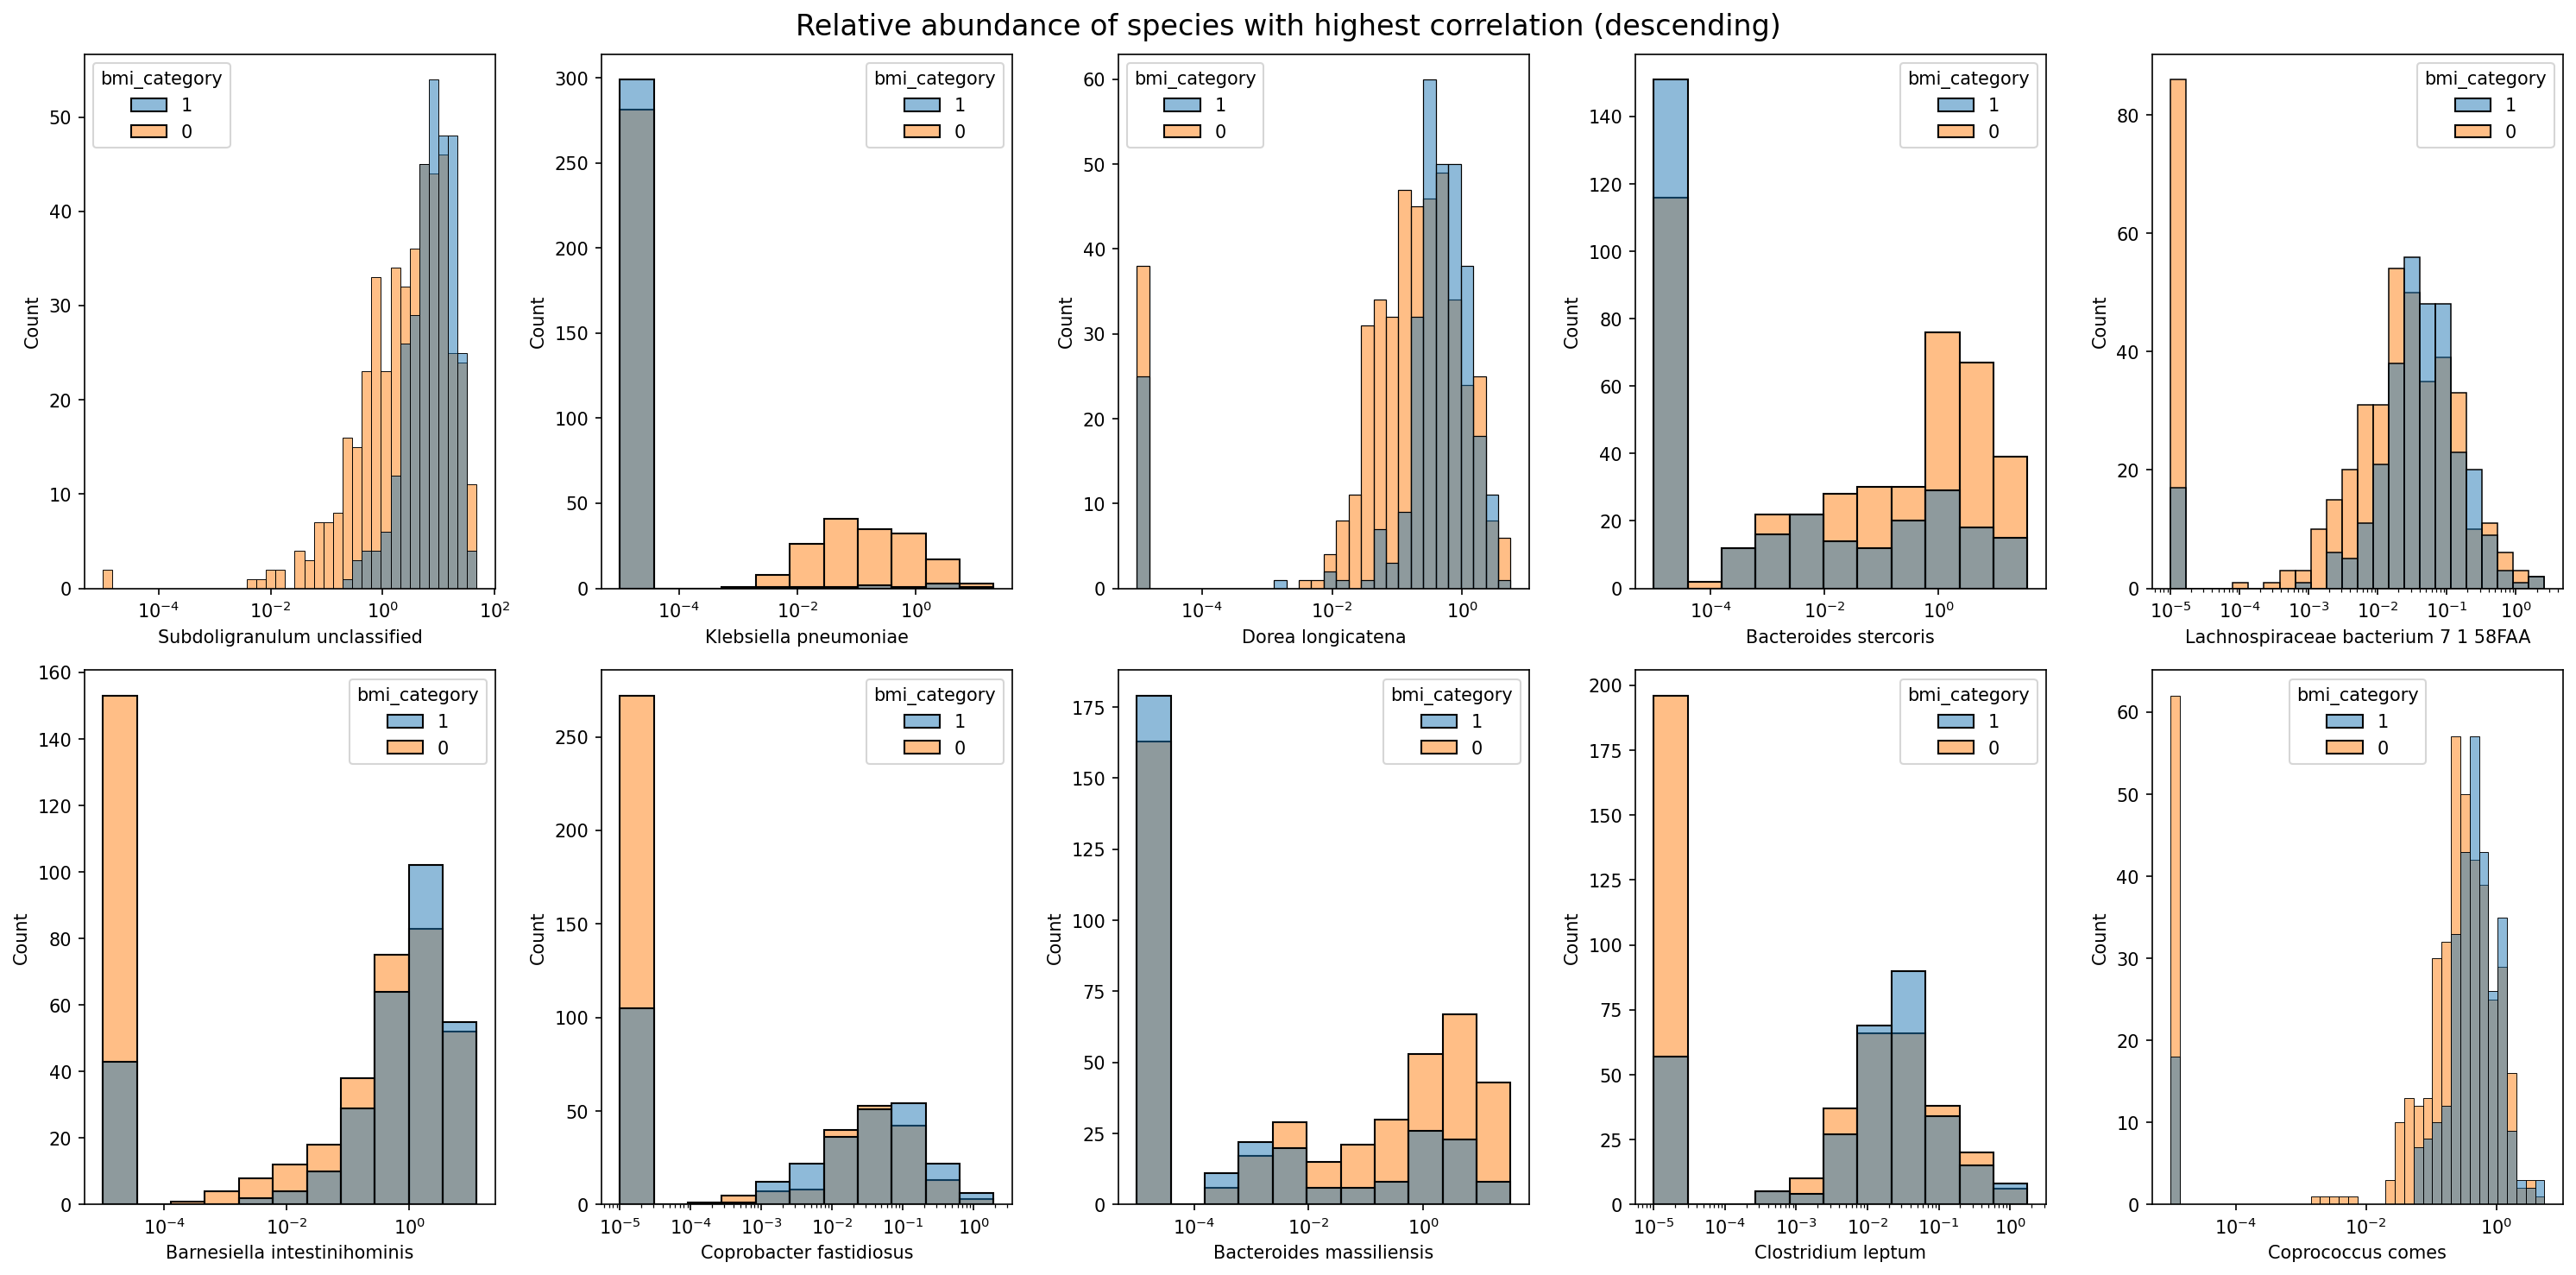

In [16]:
fig = plt.figure(figsize=(20,10), dpi=150)

topSP = species_mann.sort_values(by='rank_biserial', ascending=False).index.values[:10]

top_subset = pd.concat([(species_data[topSP] + 0.00001), species_data['bmi_category']], axis=1)

for i in range(10):
    fig.add_subplot(2, 5, i+1)
    sns.histplot(data= top_subset, x = topSP[i], hue='bmi_category', log_scale=10)
    # plt.xlim(left = 0.001)

plt.suptitle('Relative abundance of species with highest correlation (descending)', fontsize=16)
fig.set_size_inches(20, 10)
plt.tight_layout()

With the exception of the first two, I'm not seeing any major differences in the distributions of obese and normal-weight observations in the plots. This is not entirely unexpected, since I don't expect a single species to contain much information on whether an individual is obese or not, unless it is some bacteria that grows only in obese individuals and not regular individuals or vice versa. I doubt anything like that ever happens, since being overweight/obese itself is a spectrum, not some condition with a yes/no hard cutoff. And we can see here that for many species of bacteria, the relative abundance is 0 for many observations as I mentioned earlier.

But let's move on the next part and see if feature importance of the best model will coincide with these 10 species.

I intend to use classification accuracy to evaluate the models and find the best one. As a start, I like to use log regression as a baseline model and if it performs well, the coefficients become useful measures of importance. That said, I'm expecting the non-parametric or ensemble models to perform better, so I'm prepared to use other methods to determine feature importance.

The models I'll try are: 
1. Logistic regression
2. PLS-DA
3. SVM
4. Random Forest
5. Adaboost
6. Gradient Boost


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score

X = species_data.iloc[:, 7:species_data.shape[1]-1]
y = species_data.iloc[:, -1]

# split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 77)

# scale data based on training set
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)


In [8]:
# simple function to output the performance metrics of a model

def model_performance(y_true, y_pred):
    '''prints model metrics'''
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

    fig = plt.figure(dpi=100)

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=fig.gca(), display_labels=['normal','obese'])

    print(classification_report(y_true, y_pred))
    # print('balanced accuracy: {0:.4g}'.format(metrics.balance_accuracy_score(y_true, y_pred)))


# and another one to collate the scores
def model_comparison(models, names, x_test1, y_test, pls=None):
    '''Returns a dataframe of various classification metrics

    Parameters: 
    models: trained models
    names: names for models in dataframe
    x_test1: test data
    y_test: test classes
    pls: pls model, which is used to transform x_test before prediction
    
    '''

    assert len(models) == len(names), "number of models and names is not the same"

    model_scores = {}
   
    for i in range(len(names)):
        
        temp = {}
        
        if (names[i] == 'PLS-DA') :
            x_test = pls.transform(x_test1)
        else:
            x_test = x_test1

        temp['Balanced Accuracy'] = metrics.balanced_accuracy_score(y_test, models[i].predict(x_test))
        temp['ROC AUC'] = metrics.roc_auc_score(y_test, models[i].predict(x_test).astype(np.object))
        temp['Precision 1'] = metrics.precision_score(y_test, models[i].predict(x_test), pos_label = '1')
        temp['Precision 0'] = metrics.precision_score(y_test, models[i].predict(x_test), pos_label = '0')
        temp['Recall 1'] = metrics.recall_score(y_test, models[i].predict(x_test), pos_label = '1')
        temp['Recall 0'] = metrics.recall_score(y_test, models[i].predict(x_test), pos_label = '0')

        # create a dictionary for the current model
        model_scores[names[i]] = temp


        #tabulate metrics
    return pd.DataFrame.from_dict(model_scores, orient='index').round(3)


### Logistic regression ###

Since the species dataset has more variables than observations, some degree of regularisation will be necessary for a good fit.

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        89
           1       0.82      0.74      0.78        62

    accuracy                           0.83       151
   macro avg       0.83      0.81      0.82       151
weighted avg       0.83      0.83      0.83       151



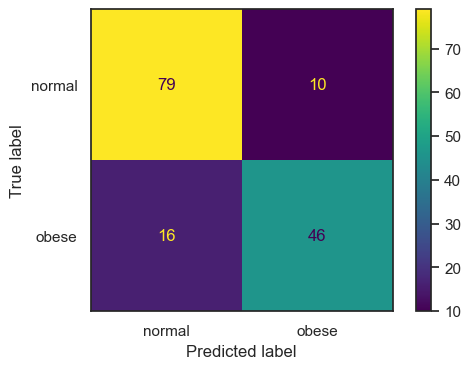

In [32]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, norm
sns.set_theme(style='white')

log_params = dict(C=uniform(loc=0.0, scale=20.0), penalty = ['l1', 'l2'])

# fit log regression
log_reg = LogisticRegression(random_state=78, max_iter=1000, solver='liblinear')

# randomized hyperparameter search
log_reg_CV = RandomizedSearchCV(log_reg, log_params, n_iter = 50, n_jobs=6, random_state = 78, scoring = 'balanced_accuracy', refit=True).fit(x_train, y_train)

log_reg_CV.best_params_

model_performance(y_test,log_reg_CV.predict(x_test))

### Partial least squares discriminant analysis ###

I learnt about this method a couple of weeks back and was quite interested in trying it out. I simply couldn't get pipeline working, so I just used a loop instead for optimisation.

no. of components for best score: 6


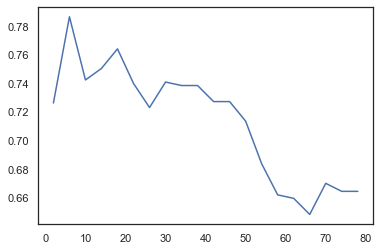

In [25]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

n_components = []
score = []

for i in np.arange(2,82,4):

    # pls model
    plsR = PLSRegression(n_components=i, scale=False).fit(x_train, y_train)

    # use components for LDA
    lda = LinearDiscriminantAnalysis().fit(plsR.x_scores_, y_train)

    n_components.append(i)
    score.append(metrics.balanced_accuracy_score(y_test, lda.predict(plsR.transform(x_test))))

plt.plot(n_components, score)

print('no. of components for best score: {}'.format(n_components[score.index(max(score))]))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83        89
           1       0.75      0.74      0.75        62

    accuracy                           0.79       151
   macro avg       0.79      0.79      0.79       151
weighted avg       0.79      0.79      0.79       151



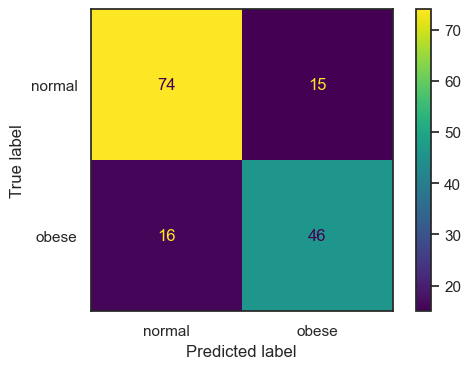

In [28]:
plsR = PLSRegression(n_components=6, scale=False).fit(x_train, y_train)

lda = LinearDiscriminantAnalysis().fit(plsR.x_scores_, y_train)

model_performance(y_test, lda.predict(plsR.transform(x_test)))

# to look at the species with highest absolute loadings
#species_data.columns[np.argsort(np.absolute(plsR.x_loadings_[:, 0]))[:10]]

The PLS-DA model appears to be comparable to the log regression model

### *a little experiment ....* ###

This idea actually occurred to me when I was almost done with this project, but since it involves logistic regression, I think it fits better here. Recall that I calculated the rank-biserial correlation earlier in this notebook, *what if I use the rank-biseral correlation as a form of feature selection?* I'll try to use features that have correlation != 0 in the logistic regression, if anything, it may improve the model it reduces the number of features.

To account for the possibility of any improvements (or degradations) in accuracy, I'll also build 3 logistic regression models where I randomly pick the same number of features and compare their accuracies.

In [18]:
# get indices of features with correlation 

idx = np.where(species_mann != 0.0)[0]

print("{} features with non-zero rank-biserial correlation".format(len(idx)))

609 features with non-zero rank-biserial correlation


In [29]:
# everything stays the same, except training and test data dimension is now reduced

log_params = dict(C=uniform(loc=0.0, scale=20.0), penalty = ['l1', 'l2'])

# fit log regression
rank_log_reg = LogisticRegression(random_state=78, max_iter=1000, solver='liblinear')

# randomized hyperparameter search
rank_log_reg_CV = RandomizedSearchCV(rank_log_reg, log_params, n_iter = 50, n_jobs=6, random_state = 78, scoring = 'balanced_accuracy', refit=True).fit(x_train[:, idx], y_train)


# random feature selection

rand_idx = [np.random.randint(0, x_train.shape[1], 609) for _ in range(3)]

rand_log_params = dict(C=uniform(loc=0.0, scale=20.0), penalty = ['l1', 'l2'])

# fit log regression
rand_log = LogisticRegression(random_state=78, max_iter=1000, solver='liblinear')

rand_acc = []

for i in rand_idx:
    rand_log_CV = RandomizedSearchCV(rand_log, rand_log_params, n_iter = 50, random_state = 78, n_jobs=6, scoring = 'balanced_accuracy', refit=True).fit(x_train[:, i], y_train)
    rand_acc.append(metrics.balanced_accuracy_score(y_test, rand_log_CV.predict(x_test[:, i])))


print("average difference in accuracy: {}".format(np.mean(metrics.balanced_accuracy_score(y_test, rank_log_reg_CV.predict(x_test[:, idx])) - np.array(rand_acc))))

average difference in accuracy: 0.08469252144496797


There are some differences in the performance, but not a huge difference or anything. Let's take a look at the metrics and confusion matrix for the rank-biserial model

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        89
           1       0.82      0.74      0.78        62

    accuracy                           0.83       151
   macro avg       0.83      0.81      0.82       151
weighted avg       0.83      0.83      0.83       151



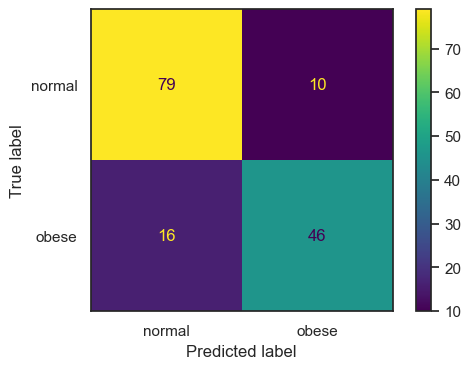

In [30]:
model_performance(y_test,rank_log_reg_CV.predict(x_test[:, idx]))

It seems like there isn't any improvement to the accuracy, in fact, both the baseline logistic regression model and this one has similar metrics and confusion matrix. It's probably because the regularisation in both models ended up choosing the same predictors. 

I'd was thinking this might be a good way to some preliminary feature selection, too bad my stroke of brilliance didn't turn out brilliantly.

(pun intended)

### Kernel SVM ###

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        89
           1       0.82      0.74      0.78        62

    accuracy                           0.83       151
   macro avg       0.83      0.81      0.82       151
weighted avg       0.83      0.83      0.83       151



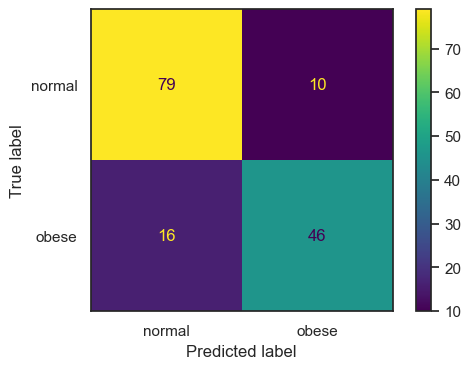

In [34]:
#step by step optimization

from sklearn.svm import SVC

svm_params = {'kernel':['rbf','sigmoid','poly'], 'C':uniform(loc=0, scale=10)}

svm = SVC(max_iter = 5000, random_state=78)

svm_cv = RandomizedSearchCV(svm, svm_params, scoring = 'balanced_accuracy', random_state = 78, n_jobs = 6, refit=True).fit(x_train, y_train)

svm_cv.best_params_

model_performance(y_test, svm_cv.predict(x_test))

### Random Forest ###

I had tried decision trees as well, but didn't get good performance so it wasn't included.

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        89
           1       0.84      0.79      0.82        62

    accuracy                           0.85       151
   macro avg       0.85      0.84      0.85       151
weighted avg       0.85      0.85      0.85       151



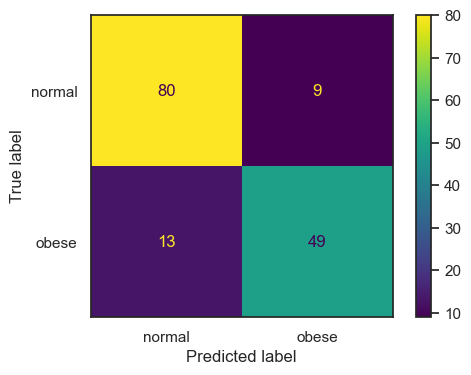

In [36]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

forest = RandomForestClassifier(random_state=78)

forest_params = {'n_estimators':randint(0, 50), 'max_features':['sqrt','log2']}

forest_cv = RandomizedSearchCV(forest, forest_params, scoring = 'balanced_accuracy', random_state = 78, n_jobs=6, refit=True).fit(x_train, y_train)

forest_cv.best_params_

model_performance(y_test, forest_cv.predict(x_test))

The random forest model is the better performing one so far, which isn't surprising, since an ensemble model like this one does have more flexibility to fit to the data better. Next let's look at boosting

### Adaboost ###

              precision    recall  f1-score   support

           0       0.87      0.92      0.90        89
           1       0.88      0.81      0.84        62

    accuracy                           0.87       151
   macro avg       0.87      0.86      0.87       151
weighted avg       0.87      0.87      0.87       151



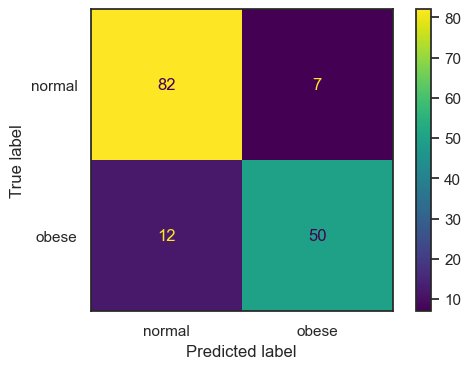

In [37]:
from sklearn.ensemble import AdaBoostClassifier


ada = AdaBoostClassifier(random_state=78)

ada_params = {'n_estimators':randint(0, 200)}

ada_cv = RandomizedSearchCV(ada, ada_params, scoring = 'balanced_accuracy', n_jobs=6, random_state = 78, refit=True).fit(x_train, y_train)

model_performance(y_test, ada_cv.predict(x_test))

### Gradient Boosting ###

              precision    recall  f1-score   support

           0       0.85      0.90      0.87        89
           1       0.84      0.77      0.81        62

    accuracy                           0.85       151
   macro avg       0.85      0.84      0.84       151
weighted avg       0.85      0.85      0.85       151



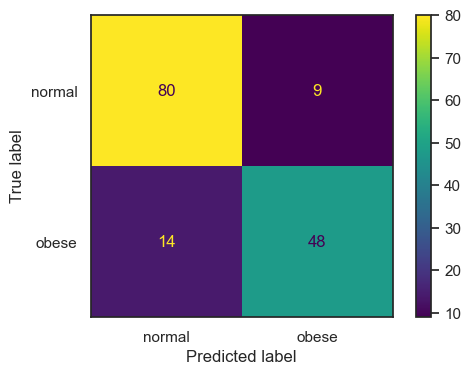

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

grad = GradientBoostingClassifier(random_state=78)

grad_params = {'n_estimators':randint(0, 300)}

grad_cv = RandomizedSearchCV(grad, grad_params, n_jobs=8, random_state = 78, refit=True).fit(x_train, y_train)

grad_cv.best_params_

model_performance(y_test, grad_cv.predict(x_test))

It seems like the Adaboost and Gradient boost models have the best performance and are quite comparable. Now let's take a look at metrics of the models.

In [39]:
models = [log_reg_CV, lda, svm_cv, forest_cv, ada_cv, grad_cv]

names = ['log regression', 'PLS-DA','kernel SVM', 'Random Forest', "Adaboost",'Gradient Boost']

model_comparison(models, names, x_test, y_test, plsR)


,Balanced Accuracy,ROC AUC,Precision 1,Precision 0,Recall 1,Recall 0
log regression,0.815,0.815,0.821,0.832,0.742,0.888
PLS-DA,0.787,0.787,0.754,0.822,0.742,0.831
kernel SVM,0.815,0.815,0.821,0.832,0.742,0.888
Random Forest,0.845,0.845,0.845,0.860,0.790,0.899
Adaboost,0.864,0.864,0.877,0.872,0.806,0.921
Gradient Boost,0.837,0.837,0.842,0.851,0.774,0.899


Let's take a look at the ROC and precision-recall plots as well. I'll only plot the 3 best performing models in this case, no point complicating the graphs needlessly.

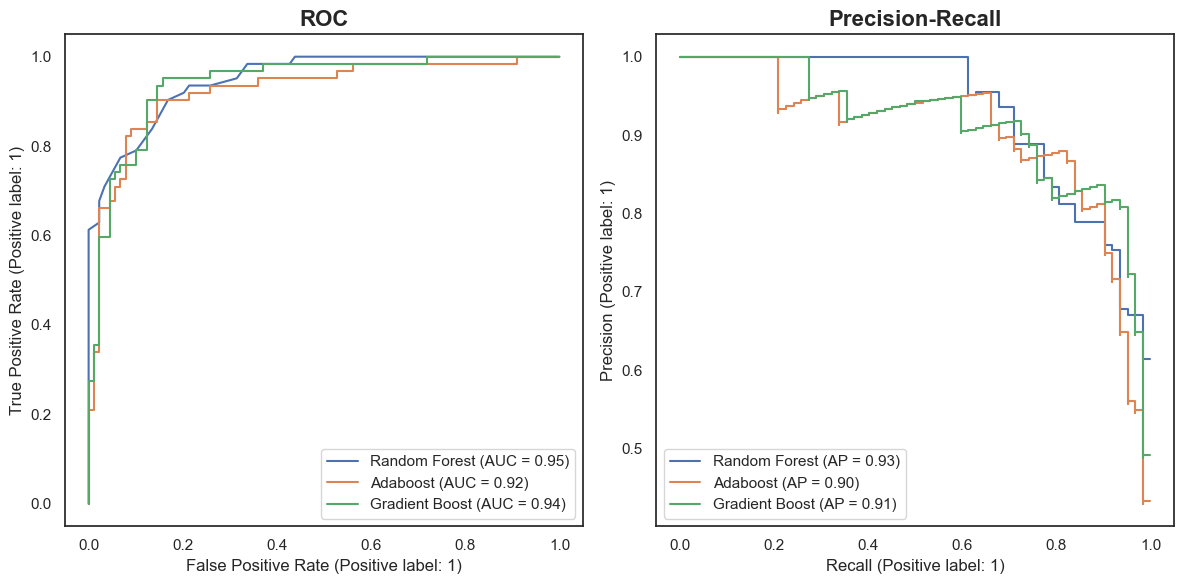

In [41]:
models = [forest_cv, ada_cv, grad_cv]

names = ['Random Forest', "Adaboost",'Gradient Boost']

fig, ax = plt.subplots(1,2, figsize=(12,6), dpi=100)

for i in range(len(names)):

    metrics.plot_roc_curve(models[i], x_test, y_test, ax=ax[0], name = names[i])
    ax[0].set_title('ROC', fontsize=16,fontweight='demibold')
    # ax[0].tick_params(axis='both', labelsize=14)
    
    metrics.plot_precision_recall_curve(models[i], x_test, y_test, ax=ax[1], name = names[i])
    ax[1].set_title('Precision-Recall', fontsize=16,fontweight='demibold')
    # ax[1].tick_params(axis='both', labelsize=14)

plt.tight_layout()

### feature importance ###

The Adaboost classifier has the best accuracy and there's even a built in [feature importance](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier.feature_importances_) measure! But impurity-based feature importance can be misleading, so the next option might be permutation importance. However, while permutation importance is useful, there are some things to take note of:

1. The calculated permutation importance is literally for that model *only*, meaning that if I were to retrain the model with a different split of the data or even a different random state, the values can come out different.

2. Also, if two features are correlated, then the overall importance will be lowered since its split between the two.

A good [read](https://christophm.github.io/interpretable-ml-book/feature-importance.html) about permutation importance, some alternatives are given [here](https://link.springer.com/article/10.1007/s11222-021-10057-z#Sec5).

One of the alternatives suggested was leave-one-covariate-out (LOCO), which seems easy enough to implement. But I'm doing this analysis on a laptop and it'll probably take it forever to do a k-fold LOCO analysis, so I won't. I'll just have to stick to permutation importance, unfortunately.

In [50]:
### permutation importance ###

from sklearn.inspection import permutation_importance
  
perm_impt = permutation_importance(ada_cv, x_test, y_test, scoring='balanced_accuracy', n_repeats=10, n_jobs=6)

perm_idx = perm_impt.importances_mean.argsort()[::-1]

print('Top 10 species by feature importance (descending):')

pd.DataFrame({'species':X.columns[perm_idx][:10], 'permutation importance':perm_impt.importances_mean[perm_idx][:10]})


Top 10 species by feature importance (descending):


,species,permutation importance
0,Streptococcus australis,0.024239
1,Lachnospiraceae bacterium 7 1 58FAA,0.023922
2,Roseburia intestinalis,0.022771
3,Faecalibacterium prausnitzii,0.021502
4,Barnesiella intestinihominis,0.021013
5,Klebsiella pneumoniae,0.020723
6,Actinomyces graevenitzii,0.019744
7,Bacteroides stercoris,0.015857
8,Oscillibacter unclassified,0.015540
9,Ruminococcus callidus,0.015123


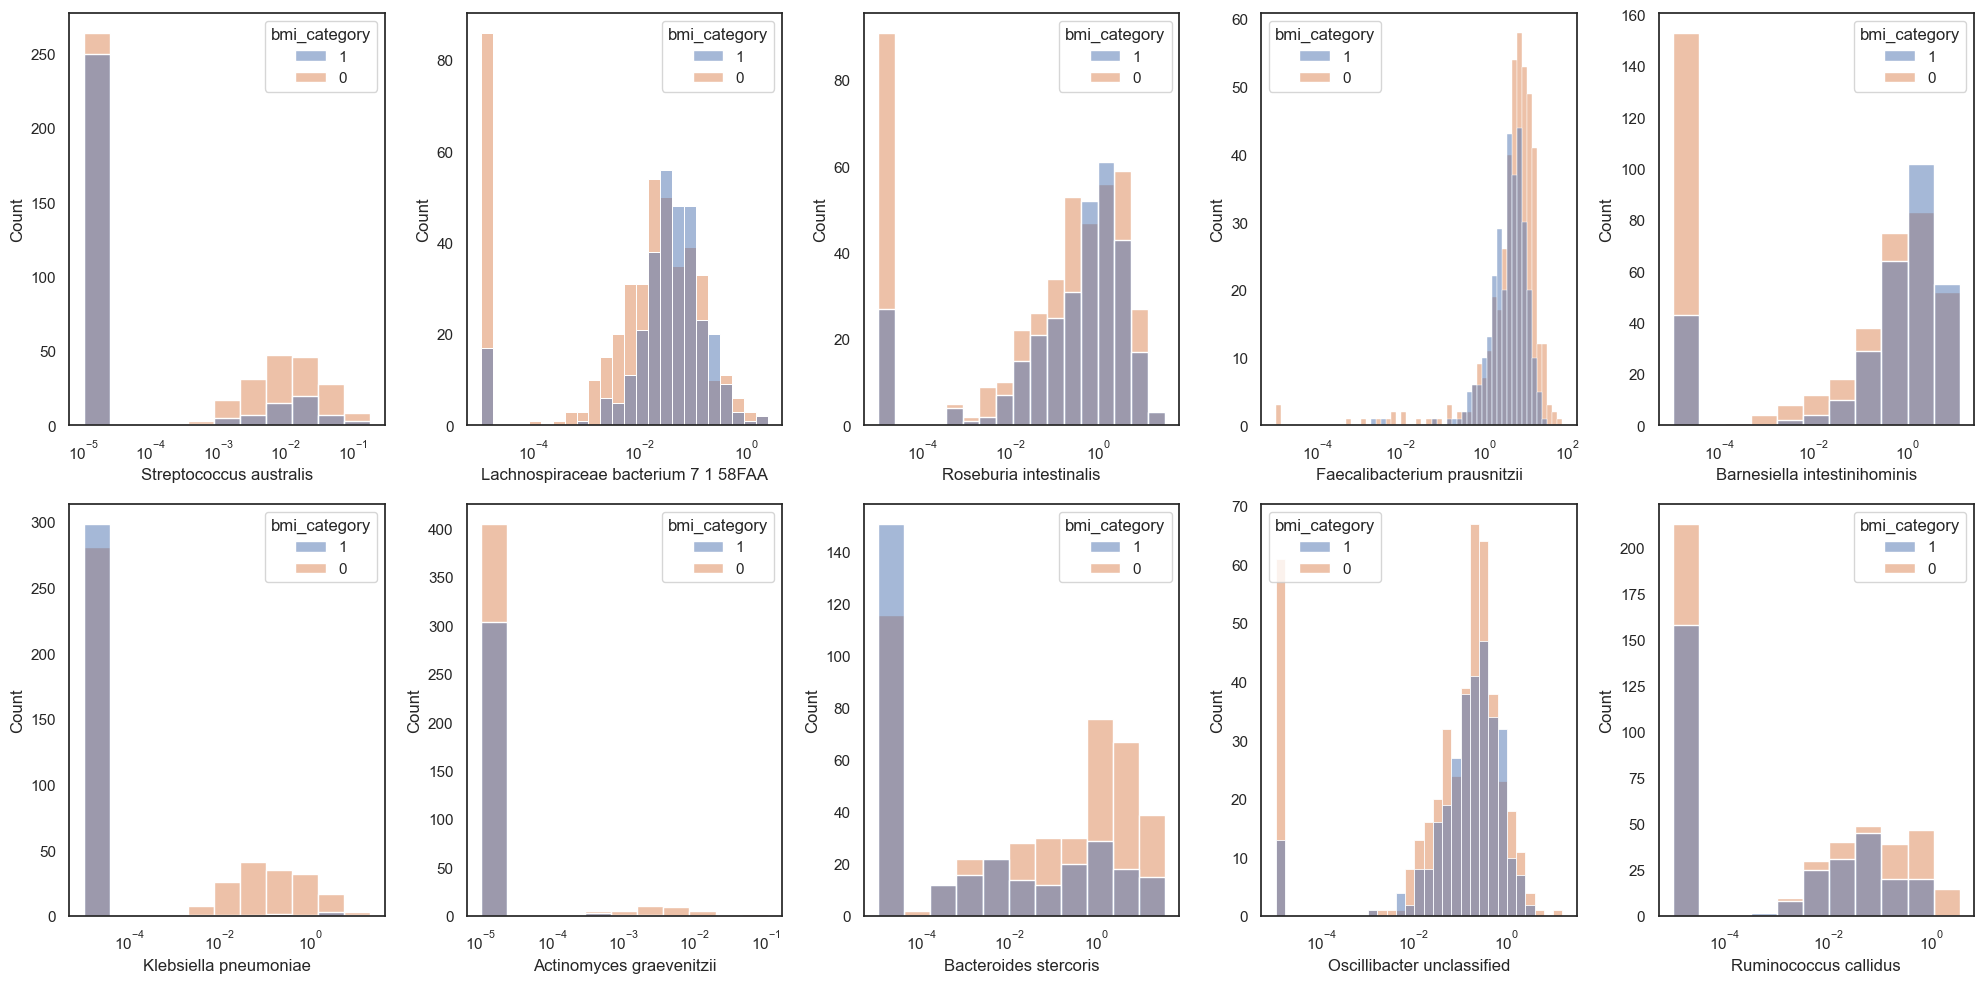

In [70]:
fig = plt.figure(figsize=(20,10), dpi=150)

impt_SP = species_data.columns[7:][perm_idx[:10]].values

impt_subset = pd.concat([(species_data[impt_SP] + 0.00001), species_data['bmi_category']], axis=1)

for i in range(10):
    fig.add_subplot(2, 5, i+1)
    sns.histplot(data= impt_subset, x = impt_SP[i], hue='bmi_category', log_scale=10)
    # plt.xlim(left = 0.001)

plt.tight_layout()

In [83]:
print('Species with high rank-biserial correlation and permutation importance:')

[x for x in impt_SP if x in topSP]

Species with high rank-biserial correlation and permutation importance:


['Lachnospiraceae bacterium 7 1 58FAA',
 'Barnesiella intestinihominis',
 'Klebsiella pneumoniae',
 'Bacteroides stercoris']

4 species with high correlation to the classes also had high permutation importance in the Adaboost model. Visually, there appears to be some differences in the distribution of relative abundance of these bacteria in obese and normal weight stools, which is nice. Then again, I was specifically looking for bacteria species with these differences in my correlation analysis, so it'd be stranger if I didn't.


### *one last model* ### 

Finally, as a epilogue or maybe the cherry on top, I'd like to try using the Adaboost model but with data grouped at genus level, just to see if there are any differences.

Grouping the data at the genus level doesn't cost too much in accuracy and the dimensions are reduced quite a bit, this might actually be be worth it in some situations.

              precision    recall  f1-score   support

           0       0.85      0.83      0.84        83
           1       0.80      0.82      0.81        68

    accuracy                           0.83       151
   macro avg       0.83      0.83      0.83       151
weighted avg       0.83      0.83      0.83       151



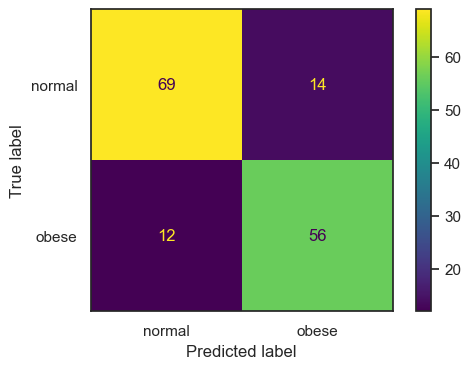

In [84]:
X = genus_data.iloc[:, 7:genus_data.shape[1]-1]
y = genus_data.iloc[:, -1]

# split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 878)

# scale data based on training set
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

ada = AdaBoostClassifier(random_state=78)

ada_params = {'n_estimators':randint(0, 200)}

ada_cv = RandomizedSearchCV(ada, ada_params, scoring = 'balanced_accuracy', n_jobs=6, random_state = 78, refit=True).fit(x_train, y_train)

model_performance(y_test, ada_cv.predict(x_test))